<a href="https://colab.research.google.com/github/SHEDOOMTC/Anti-Malarial-Activity-Prediction-Project/blob/Shadrach-Branch/S_DISCO_2025_Integrated_Approaches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<center><h1>S-DISCO - Integrated approaches</h1></center>**



---



# <font color='#FF7777'><b>Before anything else:</b></font>

<b><font color='#FF7777'>In "Connect > Change runtime type", change your hardware accelerator to "T4 GPU". </font></b>

As you will need to use a GPU to speed up your calculations, you will need to ask Google to allocate a GPU to the Colab session.


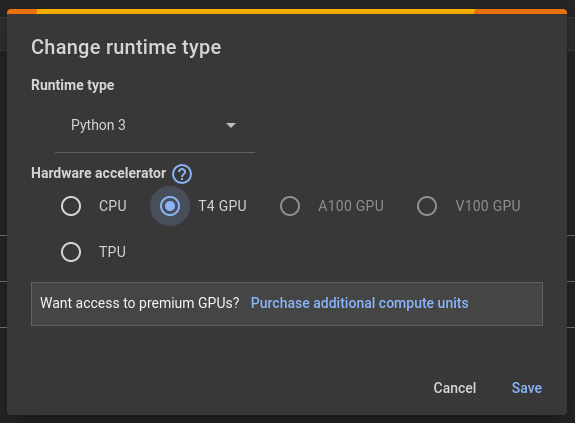

# Prerequisites

In [1]:
# @title Installation of prerequisites

################################################################################

try:
  installed
except:
  installed = 0

if installed == 0:
  !wget https://github.com/gnina/gnina/releases/download/v1.0.3/gnina
  !chmod +x gnina
  !pip install py3Dmol
  !apt install openbabel
  !pip3 install rdkit
  installed = 1
else:
  print("Already installed")

################################################################################

import os, sys
import pandas as pd
import numpy as np

from google.colab import files

import ipywidgets as widgets
from ipywidgets import interact, fixed, IntSlider
from IPython.display import Image, display, clear_output, Javascript, HTML

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px
import pydotplus

# import binana
import py3Dmol

from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, Descriptors, rdFingerprintGenerator, Draw, PandasTools, QED
from rdkit.Chem.FilterCatalog import FilterCatalogParams, FilterCatalog
RDLogger.DisableLog('rdApp.*')

from sklearn import preprocessing, decomposition, datasets, tree
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, LeaveOneOut

import warnings
warnings.filterwarnings('ignore')

################################################################################

print("\n\n\033[1mPrerequisites succesfully installed !\033[0m")

--2025-12-07 23:29:50--  https://github.com/gnina/gnina/releases/download/v1.0.3/gnina
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/45548146/6841601b-545d-4c9f-b4b1-f0eaa8ec7b74?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-08T00%3A19%3A29Z&rscd=attachment%3B+filename%3Dgnina&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-07T23%3A19%3A20Z&ske=2025-12-08T00%3A19%3A29Z&sks=b&skv=2018-11-09&sig=kbuHlw8uh9x4GwL62TsDIHvik0ThMsm8mzD6VMX%2Bal4%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2NTE1Mzc5MCwibmJmIjoxNzY1MTUwMTkwLCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5ibG9iLmNvcmUud2luZG93cy5uZXQif

In [2]:
# @title Python main functions
################################################################################

def blockPrint():
    sys.stdout = open(os.devnull, 'w')

def enablePrint():
    sys.stdout = sys.__stdout__

################################################################################

def tree_graph_to_png(tree, feature_names, class_names, png_file_to_save):
    tree_str = export_graphviz(tree, feature_names=feature_names, class_names=class_names,
                                     filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

################################################################################

def getMolDescriptors(mol, missingVal=None):
    res = {}
    for nm,fn in Descriptors._descList:
        try:
            val = fn(mol)
        except:
            val = missingVal
        res[nm] = val
    return res

################################################################################

def elimcor_sansY(X, s=0.95):
    correl = np.corrcoef(X, rowvar=False)
    stop = False
    possetap = list(range(X.shape[1]))
    groupes = {i: [i] for i in range(X.shape[1])}

    while not stop:
        # Regroup variables for which |corr| > threshold
        gplist = {}
        possglob = list(range(correl.shape[0]))
        for i in range(correl.shape[0]):
            poss = possglob[:i] + possglob[i+1:]
            gplist[i] = [i] + [poss[j] for j in range(len(poss)) if abs(correl[i, poss[j]]) > s]

        # Sort groups from largest to smallest
        gplisteff = {k: len(v) for k, v in gplist.items()}
        if any(val > 1 for val in gplisteff.values()):
            gplistfin = {k: v for k, v in gplist.items() if gplisteff[k] > 1}
            gplistuniq = [k for k, v in gplisteff.items() if v == 1]
            gpsel = []
            for i in gplistfin.values():
                selloc = min(i)
                gploc = groupes[possetap[selloc]]
                for j in i:
                    gploc.extend(groupes[possetap[j]])
                groupes[possetap[selloc]] = list(set(gploc))
                gpsel.append(selloc)
            possetap = [val for idx, val in enumerate(possetap) if idx in gplistuniq or val in set(gpsel)]
            correl = np.corrcoef(X.iloc[:,possetap], rowvar=False)
        else:
            stop = True

    return {"possetap": possetap, "groups": list(groupes.values())}

################################################################################

def top3_poses(docked_sdf, rec="rec.pdb", lig="lig.pdb", display=display):
    ids = ["Pose #1", "Pose #2", "Pose #3"]
    supplier = Chem.SDMolSupplier(docked_sdf)
    molecules = [Chem.MolToMolBlock(mol) for mol in supplier if mol is not None]
    scores = [mol.GetProp("minimizedAffinity") for mol in supplier if mol is not None]

    lig_ref = Chem.MolFromPDBFile(lig)
    # rmsd = [AllChem.CalcRMS(lig_ref, mol, map=lig_ref.GetSubstructMatch(mol)) for mol in supplier if mol is not None]

    html_str = '''
    <table class="center">
    <tr>
    <td><h2 style="text-align:center;">{0}</h2></td>
    <td><h2 style="text-align:center;">{1}</h2></td>
    <td><h2 style="text-align:center;">{2}</h2></td>
    </tr>
    <tr>
    <td id="{0}">{3}</td>
    <td id="{1}">{4}</td>
    <td id="{2}">{5}</td>
    </tr>
    </table>
    '''

    html_str = html_str.format(ids[0], ids[1], ids[2], scores[0], scores[1], scores[2])
    display(HTML(html_str))

    for i in range(3):
        viewer = py3Dmol.view(width=400, height=400)
        viewer.addModel(open('rec.pdb').read())
        viewer.setStyle({'cartoon':{},'stick':{'radius':0.15}})
        viewer.addModel(open('lig.pdb').read())
        viewer.setStyle({'model':1},{'stick':{'colorscheme':'greenCarbon'}})
        viewer.addModel(molecules[i])
        viewer.setStyle({'model':2},{'stick':{'colorscheme':'cyanCarbon'}})
        viewer.zoomTo({'model':1})
        viewer.insert(ids[i])
    return

#####

def CB_Gnina_pandas(input_sdf, active):
    temp = PandasTools.LoadSDF(input_sdf)
    temp["minimizedAffinity"] = pd.to_numeric(temp["minimizedAffinity"])
    temp = temp.sort_values("minimizedAffinity").drop_duplicates("ID")
    temp.index = range(len(temp))

    temp["Active"] = active
    temp[["MW", "LogP", "HBA", "HBD", "PSA", "RotB", "Arom", "Alerts", "PAINS"]] = 0

    smiles_list = []
    for rowid_temp in range(len(temp)):
        smiles_list.append(Chem.MolToSmiles(temp.loc[rowid_temp,"ROMol"]))
        temp.loc[rowid_temp, ["MW", "LogP", "HBA", "HBD", "PSA", "RotB", "Arom", "Alerts"]] = [round(i,2) for i in QED.properties(temp["ROMol"][rowid_temp])]

    temp["ROMol"] = smiles_list
    return temp


#####

def CB_AUC(data_x, data_y):
    calculated_auc = 0
    for i in range(len(data_x)-1):
        auc_temp = (data_y[i] + data_y[i+1]) * (data_x[i+1] - data_x[i]) / 2
        calculated_auc = calculated_auc + auc_temp
    return calculated_auc

################################################################################

print("\033[1mFunctions succesfully loaded !\033[0m")

Functions succesfully loaded !


In [3]:
# @title Download/load data
################################################################################

!wget -nc https://github.com/cbedart/S-DISCO/raw/refs/heads/2025/cah2_input_subset_2025.pkl > /dev/null 2>&1
!wget -nc https://github.com/cbedart/S-DISCO/raw/refs/heads/2025/cah2_topredict_subset_2025.pkl > /dev/null 2>&1

!wget -nc https://github.com/cbedart/S-DISCO/raw/refs/heads/2023/results_cah2_docking.pkl > /dev/null 2>&1
!wget -nc https://github.com/cbedart/S-DISCO/raw/refs/heads/2023/CAH2_1BCD_prep.mol2 > /dev/null 2>&1
!wget -nc https://github.com/cbedart/S-DISCO/raw/refs/heads/2023/conf.txt > /dev/null 2>&1

!wget -nc https://github.com/cbedart/S-DISCO/raw/refs/heads/2025/cah2_input_desc_noNA_2025.pkl > /dev/null 2>&1
!wget -nc https://github.com/cbedart/S-DISCO/raw/refs/heads/2025/cah2_input_fps_noNA_2025.zip > /dev/null 2>&1
!unzip -u cah2_input_fps_noNA_2025.zip > /dev/null 2>&1

!wget -nc https://github.com/cbedart/S-DISCO/raw/refs/heads/2025/cah2_topredict_input_desc_noNA_2025.pkl > /dev/null 2>&1
!wget -nc https://github.com/cbedart/S-DISCO/raw/refs/heads/2025/cah2_topredict_input_fps_noNA_2025.pkl > /dev/null 2>&1

cah2_input_subset = pd.read_pickle("cah2_input_subset_2025.pkl")
cah2_topredict_subset = pd.read_pickle("cah2_topredict_subset_2025.pkl").sort_values("Name")
cah2_input_desc_noNA = pd.read_pickle("cah2_input_desc_noNA_2025.pkl")
cah2_input_fps_noNA = pd.read_pickle("cah2_input_fps_noNA_2025.pkl")
cah2_topredict_input_desc_noNA = pd.read_pickle("cah2_topredict_input_desc_noNA_2025.pkl")
cah2_topredict_input_fps_noNA = pd.read_pickle("cah2_topredict_input_fps_noNA_2025.pkl")

results_cah2_temp = pd.read_pickle("results_cah2_docking.pkl")
results_cah2_VA = results_cah2_temp["VA"]
results_cah2_CS = results_cah2_temp["CS"]
results_cah2_CA = results_cah2_temp["CA"]
results_cah2_VS = results_cah2_temp["VS"]

# Data presentation

**Protein** = Carbonic Anhydrase II (CAH2)  
**UniProt ID** = <a href="https://www.uniprot.org/uniprotkb/P00918/entry">P00918</a>  
**PDB ID** = <a href="https://www.rcsb.org/structure/1BCD">1BCD</a>  
<br />
**Retrospective virtual screening data** = <a href="https://dude.docking.org/targets/cah2">DUD-E subset with 492 active ligands and 31,172 decoys</a>  
**QSAR/Machine learning data** = <a href="https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL205/">CHEMBL205</a>  
<br />
**Main objectives of the practical session:**
* 4 different ligands assigned to each person, with a subset ID between 1 and 8 (so be sure to use your own ID).
* At least one "active" (Ki < 2nM), at least one "inactive" (Ki > 5µM).
* Using the various methods covered in the previous sessions, describe whether your ligands can be considered active or inactive.
* If your only argument is to look at the data available on the internet, it's automatically the worst grading possible. We want you to give us rational thought and descriptions, even if nothing works and you identify everything as inactive or active.

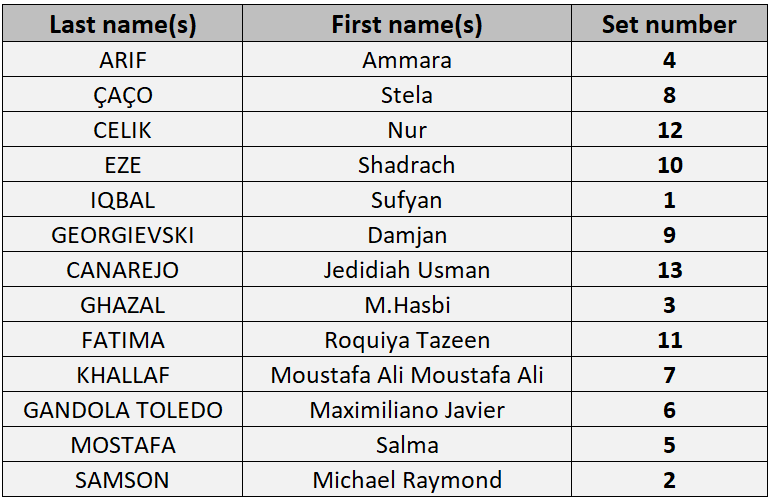

,Name,Group,Smiles,RDKit,MolWt,LogP,HBA,HBD,TPSA,RotB
0,ToPredict_15,10.0,NS(=O)(=O)Oc1ccc(NC(=O)NC2c3ccccc3-c3ccccc32)cc1,<rdkit.Chem.rdchem.Mol object at 0x7ebb9cee2ed0>,395.44,3.16,4,3,110.52,4
1,ToPredict_21,10.0,NS(=O)(=O)c1ccc(CC/N=C2\C(=O)N(Cc3ccccc3)c3ccc...,<rdkit.Chem.rdchem.Mol object at 0x7ebb9cee2a70>,419.51,2.91,3,1,92.83,6
2,ToPredict_24,10.0,CC(=O)N1N=C(c2ccc(C)cc2)CC1c1c(C)nn(-c2ccc(S(N...,<rdkit.Chem.rdchem.Mol object at 0x7ebb9cee25c0>,471.97,3.49,4,1,110.65,4
3,ToPredict_39,10.0,COc1cc2nccc(Oc3ccc(NC(=O)NC4CC4)c(Cl)c3)c2cc1C...,<rdkit.Chem.rdchem.Mol object at 0x7ebb9cee3100>,426.86,4.07,5,3,115.57,6


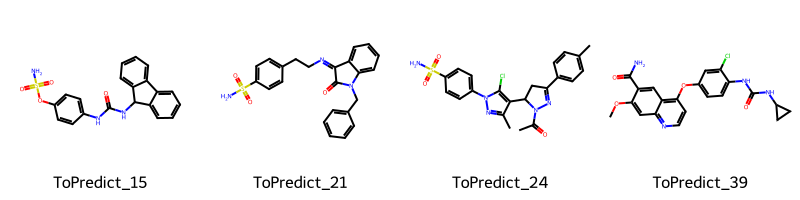

In [4]:
# @markdown <b><font color="#FF7777">Please setup your subsetID below:</font></b>

subsetID = 10 # @param [1,2,3,4,5,6,7,8,9,10,11,12,13] {type:"raw"}

if subsetID == 0:
  print("Your subset is not properly defined - Change it")
else:
  cah2_topredict_group = cah2_topredict_subset[cah2_topredict_subset["Group"] == subsetID]
  cah2_topredict_group.index = range(len(cah2_topredict_group))
  display(cah2_topredict_group)

  display(Draw.MolsToGridImage([Chem.MolFromSmiles(cah2_topredict_group["Smiles"].loc[i]) for i in range(len(cah2_topredict_group))],molsPerRow=4,subImgSize=(200,200),legends=cah2_topredict_group["Name"].to_list()))

# <b><font color="#FF7777"> Virtual screening using Gnina </b></font>

,Scoring Function,Enrichment factor at 0.5%,Correspond to a score of
0,Vina Affinity,2.44,Below -9.68
1,CNN Score,42.64,Above 0.9
2,CNN Affinity,22.34,Above 7.37
3,CNN VS,46.70,Above 6.14


Maximum enrichment factor at 0.5% than can be obtained = 64.16



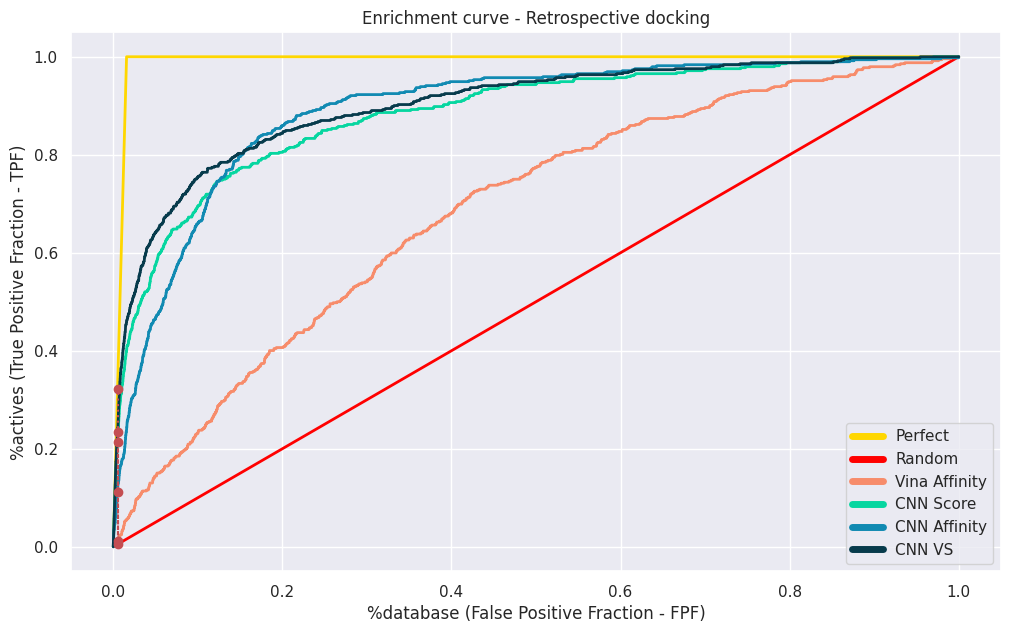

In [9]:
# @title <b>Retrospective docking</b>

# @markdown Total of <b>31,569</b> compounds with <b>492</b> active compounds and <b>31,077</b> decoys.
top_percent = 0.5 # @param {type:"slider", min:0.1, max:5, step:0.1}
xlog_scale = False # @param {type:"boolean"}

nb_actives = results_cah2_VA.value_counts("Active")[1]
enrich_VA = [0] + list(results_cah2_VA.sort_values("minimizedAffinity", ascending=True)["Active"].cumsum() / nb_actives)
enrich_CS = [0] + list(results_cah2_CS.sort_values("CNNscore", ascending=False)["Active"].cumsum() / nb_actives)
enrich_CA = [0] + list(results_cah2_CA.sort_values("CNNaffinity", ascending=False)["Active"].cumsum() / nb_actives)
enrich_VS = [0] + list(results_cah2_VS.sort_values("CNN_VS", ascending=False)["Active"].cumsum() / nb_actives)

enrich_random = [i/nb_actives for i in np.linspace(0,nb_actives,len(results_cah2_VA)+1)]
enrich_perfect = [i/nb_actives for i in list(range(0,nb_actives+1)) + list(np.repeat(nb_actives,len(results_cah2_VA)-nb_actives))]

enrich_xaxis = np.linspace(0, 1, len(enrich_VA))

plt.figure(figsize=[12,7])
plt.title("Enrichment curve - Retrospective docking")

# retrospective_colors = ["#FFD166", "#EF476F", "#F78C6B", "#06D6A0", "#118AB2", "#073B4C"]
retrospective_colors = ["gold", "red", "#F78C6B", "#06D6A0", "#118AB2", "#073B4C"]

plt.plot(enrich_xaxis, enrich_perfect, color = retrospective_colors[0], linewidth=2)
plt.plot(enrich_xaxis, enrich_random, color = retrospective_colors[1], linewidth=2)

plt.plot(enrich_xaxis, enrich_VA, color = retrospective_colors[2], linewidth=2)
plt.plot(enrich_xaxis, enrich_CS, color = retrospective_colors[3], linewidth=2)
plt.plot(enrich_xaxis, enrich_CA, color = retrospective_colors[4], linewidth=2)
plt.plot(enrich_xaxis, enrich_VS, color = retrospective_colors[5], linewidth=2)

leg = plt.legend(["Perfect", "Random", "Vina Affinity", "CNN Score", "CNN Affinity", "CNN VS"])
for line in leg.get_lines():
    line.set_linewidth(5)

plt.xlabel("%database (False Positive Fraction - FPF)")
plt.ylabel("%actives (True Positive Fraction - TPF)")

if xlog_scale:
  plt.xscale("log")

top_percent = top_percent / 100
top_id = round(len(results_cah2_VA)*top_percent)

plt.plot([enrich_xaxis[top_id], enrich_xaxis[top_id], enrich_xaxis[top_id], enrich_xaxis[top_id], enrich_xaxis[top_id], enrich_xaxis[top_id]], [enrich_VA[top_id], enrich_CA[top_id], enrich_CS[top_id], enrich_VS[top_id],enrich_random[top_id], enrich_perfect[top_id]], "ro", zorder=100, linestyle="dotted")

enrichment_factors = [round(enrich_VA[top_id] / enrich_random[top_id], 2),
                      round(enrich_CS[top_id] / enrich_random[top_id], 2),
                      round(enrich_CA[top_id] / enrich_random[top_id], 2),
                      round(enrich_VS[top_id] / enrich_random[top_id], 2)]

enrichment_scores = ["Below {}".format(round(results_cah2_VA["minimizedAffinity"].sort_values(ascending=True).iloc[top_id],2)),
                     "Above {}".format(round(results_cah2_CS["CNNscore"].sort_values(ascending=False).iloc[top_id],2)),
                     "Above {}".format(round(results_cah2_CA["CNNaffinity"].sort_values(ascending=False).iloc[top_id],2)),
                     "Above {}".format(round(results_cah2_VS["CNN_VS"].sort_values(ascending=False).iloc[top_id],2))]

retrospective_results = pd.DataFrame({"Scoring Function":["Vina Affinity", "CNN Score", "CNN Affinity", "CNN VS"],
                                      "Enrichment factor at {0}%".format(round(top_percent*100,2)):enrichment_factors,
                                      "Correspond to a score of":enrichment_scores})

display(retrospective_results)

print("Maximum enrichment factor at {}% than can be obtained = {}\n".format(round(top_percent*100,2), round(enrich_perfect[top_id] / enrich_random[top_id], 2)))

plt.show()




In [10]:
# @title <b>Step #1 - Virtual screening of the 4 ligands</b>
# @markdown Exact same conditions as the retrospective virtual screening

# @markdown Box information = conf.txt
# cah2_topredict_group
temp_3D = []

for mol in cah2_topredict_group["RDKit"]:
  mol = Chem.AddHs(mol)
  AllChem.EmbedMolecule(mol, useExpTorsionAnglePrefs = True, useBasicKnowledge = True)

with Chem.SDWriter('CAH2_topredict.sdf') as w:
  for i in range(len(cah2_topredict_group)):
    mol = cah2_topredict_group.loc[i,"RDKit"]
    mol.SetProp("_Name", cah2_topredict_group.loc[i,"Name"])
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, useExpTorsionAnglePrefs = True, useBasicKnowledge = True)
    w.write(mol)

!./gnina --receptor CAH2_1BCD_prep.mol2 --ligand CAH2_topredict.sdf --config conf.txt --out CAH2_topredict_docked.sdf --log CAH2_topredict_log.txt --num_modes=3

              _             
             (_)            
   __ _ _ __  _ _ __   __ _ 
  / _` | '_ \| | '_ \ / _` |
 | (_| | | | | | | | | (_| |
  \__, |_| |_|_|_| |_|\__,_|
   __/ |                    
  |___/                     

gnina  master:e9cb230+   Built Feb 11 2023.
gnina is based on smina and AutoDock Vina.
Please cite appropriately.

Commandline: ./gnina --receptor CAH2_1BCD_prep.mol2 --ligand CAH2_topredict.sdf --config conf.txt --out CAH2_topredict_docked.sdf --log CAH2_topredict_log.txt --num_modes=3
*** Open Babel Warning  in ReadMolecule
  Failed to kekulize aromatic bonds in MOL2 file (title is 1BCD)

Using random seed: 1575536288

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
ToPredict_15 | pose 0 | initial pose not within box

mode |  affinity  |    CNN     |   CNN
     | (kcal/mol) | pose score | affinity
-----+------------+------------+----------
    1 

In [12]:
# @title <b>Step #2 - Postprocessing of the 4 docked ligands</b>

# @markdown Please choose the scoring function that you consider the most suitable.
scoring_function = "CNN VS" # @param ["Vina Affinity", "CNN Score", "CNN Affinity", "CNN VS"]

# @markdown At the end, the script will automatically download the best pose for each of your ligand.

temp = PandasTools.LoadSDF("CAH2_topredict_docked.sdf", molColName=None, idName="Molecule_Name")
temp["DockedID"] = range(1,13)

if scoring_function == "Vina Affinity":
  temp["minimizedAffinity"] = pd.to_numeric(temp["minimizedAffinity"])
  temp_sorted = temp.sort_values("minimizedAffinity", ascending=True).drop_duplicates("Molecule_Name")
elif scoring_function == "CNN Score":
  temp["CNNscore"] = pd.to_numeric(temp["CNNscore"])
  temp_sorted = temp.sort_values("CNNscore", ascending=False).drop_duplicates("Molecule_Name")
elif scoring_function == "CNN Affinity":
  temp["CNNaffinity"] = pd.to_numeric(temp["CNNaffinity"])
  temp_sorted = temp.sort_values("CNNaffinity", ascending=False).drop_duplicates("Molecule_Name")
elif scoring_function == "CNN VS":
  temp["CNN_VS"] = pd.to_numeric(temp["CNN_VS"])
  temp_sorted = temp.sort_values("CNN_VS", ascending=False).drop_duplicates("Molecule_Name")
temp_sorted.index = range(len(temp_sorted))
display(temp_sorted)

!mkdir topredict_docked
!obabel -i sdf CAH2_topredict_docked.sdf -o sdf -O topredict_docked/CAH2_topredict_docked.sdf -m

!obabel -i sdf topredict_docked/CAH2_topredict_docked{temp_sorted.loc[0,"DockedID"]}.sdf topredict_docked/CAH2_topredict_docked{temp_sorted.loc[1,"DockedID"]}.sdf topredict_docked/CAH2_topredict_docked{temp_sorted.loc[2,"DockedID"]}.sdf topredict_docked/CAH2_topredict_docked{temp_sorted.loc[3,"DockedID"]}.sdf -o sdf -O CAH_topredict_bestposes.sdf

files.download("CAH2_topredict_docked.sdf")
files.download("CAH_topredict_bestposes.sdf")

,minimizedAffinity,CNNscore,CNNaffinity,CNN_VS,CNNaffinity_variance,Molecule_Name,DockedID
0,-8.74069,0.9441008568,7.3838148117,6.971066,0.4955586791,ToPredict_21,5
1,-9.51320,0.8064852953,7.6801557541,6.193933,0.3054366410,ToPredict_24,7
2,-8.13194,0.7655924559,6.6674499512,5.104549,0.3992431164,ToPredict_15,1
3,-6.68637,0.6816583872,7.1627416611,4.882543,0.2590860724,ToPredict_39,10


mkdir: cannot create directory ‘topredict_docked’: File exists
12 molecules converted
12 files output. The first is topredict_docked/CAH2_topredict_docked1.sdf
4 molecules converted


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

from matplotlib import pyplot as plt
temp_sorted['CNN_VS'].plot(kind='hist', bins=20, title='CNN_VS')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
temp_sorted['DockedID'].plot(kind='hist', bins=20, title='DockedID')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
temp_sorted.groupby('minimizedAffinity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
temp_sorted.groupby('CNNscore').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
temp_sorted.groupby('CNNaffinity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
temp_sorted.groupby('CNNaffinity_variance').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
temp_sorted.plot(kind='scatter', x='CNN_VS', y='DockedID', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
temp_sorted['CNN_VS'].plot(kind='line', figsize=(8, 4), title='CNN_VS')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
temp_sorted['DockedID'].plot(kind='line', figsize=(8, 4), title='DockedID')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['CNNscore'].value_counts()
    for x_label, grp in temp_sorted.groupby('minimizedAffinity')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('minimizedAffinity')
_ = plt.ylabel('CNNscore')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['CNNaffinity'].value_counts()
    for x_label, grp in temp_sorted.groupby('CNNscore')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('CNNscore')
_ = plt.ylabel('CNNaffinity')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['CNNaffinity_variance'].value_counts()
    for x_label, grp in temp_sorted.groupby('CNNaffinity')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('CNNaffinity')
_ = plt.ylabel('CNNaffinity_variance')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Molecule_Name'].value_counts()
    for x_label, grp in temp_sorted.groupby('CNNaffinity_variance')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('CNNaffinity_variance')
_ = plt.ylabel('Molecule_Name')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(temp_sorted['minimizedAffinity'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(temp_sorted, x='CNN_VS', y='minimizedAffinity', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(temp_sorted['CNNscore'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(temp_sorted, x='CNN_VS', y='CNNscore', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(temp_sorted['CNNaffinity'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(temp_sorted, x='CNN_VS', y='CNNaffinity', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(temp_sorted['CNNaffinity_variance'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(temp_sorted, x='CNN_VS', y='CNNaffinity_variance', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

# <b><font color="#FF7777">QSAR/Machine learning - Dataset preparation</b></font>

In [16]:
# @title <b>Input descriptors preparation</b>
# @markdown This time, you can choose between the physicochemical descriptors (= the same 202 descriptors used previously), the 1024 bits fingerprints, or the two subsets merged together.
physicochemical_descriptors = True # @param {type:"boolean"}
fingerprints = True # @param {type:"boolean"}

# @markdown Data cleaning - Minimum pKi to take into account (between 0 and 15):
min_pKi = 5 # @param {type:"raw"}

# @markdown Maximum correlation coefficient between your chosen descriptors (Default = 0.9 // Max = 1 // Min = 0):
max_correlation = 0.9 # @param {type:"raw"}

# @markdown Split between training and test datasets (Default 0.2 // Min 0 // Max 1):
test_split = 0.25 # @param {type:"raw"}

if physicochemical_descriptors == True and fingerprints == False:
  desc_CAH2_noNA_prep = cah2_input_desc_noNA
  desc_CAH2_topredict_noNA_prep = cah2_topredict_input_desc_noNA
elif physicochemical_descriptors == False and fingerprints == True:
  desc_CAH2_noNA_prep = cah2_input_fps_noNA
  desc_CAH2_topredict_noNA_prep = cah2_topredict_input_fps_noNA
elif physicochemical_descriptors == True and fingerprints == True:
  desc_CAH2_noNA_prep = pd.concat([cah2_input_desc_noNA, cah2_input_fps_noNA.iloc[:,3:]], axis = 1)
  desc_CAH2_topredict_noNA_prep = pd.concat([cah2_topredict_input_desc_noNA, cah2_topredict_input_fps_noNA.iloc[:,2:]], axis = 1)
else:
  #@ markdown ISSUES
  raise ValueError("Check at least one parameters")

desc_CAH2_topredict_noNA_prep = desc_CAH2_topredict_noNA_prep[cah2_topredict_input_desc_noNA["Group"] == subsetID]
desc_CAH2_topredict_noNA_prep.index = range(len(desc_CAH2_topredict_noNA_prep))

################################################################################

print("\033[1mStart = Dataset of {} compounds with {} descriptors\033[0m\n".format(len(desc_CAH2_noNA_prep), len(desc_CAH2_noNA_prep.columns)-3))

################################################################################

print("-> Data cleaning")

# Remove Ipc as it seems to big
if "Ipc" in desc_CAH2_noNA_prep.columns:
  desc_CAH2_noNA_prep = desc_CAH2_noNA_prep.drop("Ipc", axis=1)

if len(desc_CAH2_noNA_prep[desc_CAH2_noNA_prep["pKi"] <= min_pKi]) > 0:
  desc_CAH2_noNA = desc_CAH2_noNA_prep[desc_CAH2_noNA_prep["pKi"] > min_pKi]
  desc_CAH2_noNA.index = range(len(desc_CAH2_noNA))
  print("\033[1mFrom {} to {} compounds\033[0m\n".format(len(desc_CAH2_noNA_prep), len(desc_CAH2_noNA)))
else:
  desc_CAH2_noNA = desc_CAH2_noNA_prep
  print("")

desc_CAH2_topredict_noNA_prep = pd.concat([desc_CAH2_topredict_noNA_prep.iloc[:,:2], desc_CAH2_topredict_noNA_prep.loc[:,desc_CAH2_noNA.columns[3:]]], axis = 1)

################################################################################

print("-> Normalization/Scaling")
scaler = preprocessing.StandardScaler()
scaler.fit(desc_CAH2_noNA.iloc[:,3:].to_numpy(dtype=np.float64))

normalizer = preprocessing.Normalizer()
normalizer.fit(desc_CAH2_noNA.iloc[:,3:].to_numpy(dtype=np.float64))

norm_temp = pd.DataFrame(normalizer.transform(scaler.transform(desc_CAH2_noNA.iloc[:,3:].to_numpy(dtype=np.float64))))
norm_temp.columns = desc_CAH2_noNA.iloc[:,3:].columns
desc_CAH2_norm = pd.concat([desc_CAH2_noNA.iloc[:,:3], norm_temp], axis="columns")
desc_CAH2_norm = desc_CAH2_norm.dropna(axis="columns")

norm_topredict_temp = pd.DataFrame(normalizer.transform(scaler.transform(desc_CAH2_topredict_noNA_prep.iloc[:,2:].to_numpy(dtype=np.float64))))
norm_topredict_temp.columns = desc_CAH2_topredict_noNA_prep.iloc[:,2:].columns
desc_CAH2_topredict_norm = pd.concat([desc_CAH2_topredict_noNA_prep.iloc[:,:2], norm_topredict_temp], axis="columns")
desc_CAH2_topredict_norm = desc_CAH2_topredict_norm.dropna(axis="columns")

if len(desc_CAH2_noNA.columns)-3 == len(desc_CAH2_norm.columns)-3:
  print("")
else:
  print("\033[1mFrom {} to {} descriptors\033[0m\n".format(len(desc_CAH2_noNA.columns)-3, len(desc_CAH2_norm.columns)-3))

################################################################################

print("-> Remove highly correlated descriptors - Below {}".format(max_correlation))

X = desc_CAH2_norm.iloc[:,3:]
elimcor = elimcor_sansY(X, float(max_correlation))

desc_CAH2_nocorr = pd.concat([desc_CAH2_norm.iloc[:,:3], X.iloc[:,elimcor["possetap"]]], axis="columns")
desc_CAH2_topredict_nocorr = pd.concat([desc_CAH2_topredict_norm.iloc[:,:2], desc_CAH2_topredict_norm.iloc[:,2:].iloc[:,elimcor["possetap"]]], axis="columns")

print("\033[1mFrom {} to {} descriptors\033[0m\n".format(len(desc_CAH2_norm.columns)-3, len(desc_CAH2_nocorr.columns)-3))

################################################################################

print("-> Split of the dataset between training and test subsets:")

X = desc_CAH2_nocorr.iloc[:,3:]
y = desc_CAH2_nocorr.loc[:,"pKi"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=float(test_split))

print("\033[1mTraining subset = {} % with {} compounds\033[0m".format(100*(1-float(test_split)), len(X_train)))
print("\033[1mTest subset = {} % with {} compounds\033[0m\n".format(100*(float(test_split)), len(X_test)))

display(desc_CAH2_nocorr)
display(desc_CAH2_topredict_nocorr)




Start = Dataset of 7891 compounds with 1229 descriptors

-> Data cleaning
From 7891 to 6532 compounds

-> Normalization/Scaling

-> Remove highly correlated descriptors - Below 0.9
From 1228 to 1172 descriptors

-> Split of the dataset between training and test subsets:
Training subset = 75.0 % with 4899 compounds
Test subset = 25.0 % with 1633 compounds



,Name,Ki,pKi,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,NumRadicalElectrons,...,ECFP4_1015,ECFP4_1016,ECFP4_1017,ECFP4_1018,ECFP4_1019,ECFP4_1020,ECFP4_1021,ECFP4_1022,ECFP4_1023,ECFP4_1024
0,Molecule_904,0.008,11.097,0.000588,0.003095,0.003740,0.041909,0.012189,-0.014836,-0.001065,...,-0.002991,-0.004922,-0.003340,-0.003674,-0.002215,-0.013143,-0.007373,-0.004142,-0.002081,-0.001581
1,Molecule_3950,0.009,11.046,0.007673,0.041193,-0.002703,-0.028210,0.073666,-0.011931,-0.001275,...,-0.003581,-0.005893,-0.003999,-0.004399,-0.002652,0.067427,-0.008829,-0.004960,-0.002492,-0.001894
2,Molecule_6501,0.009,11.046,-0.001486,-0.003471,0.004200,0.047527,0.013205,-0.018039,-0.001070,...,-0.003005,-0.004945,-0.003356,-0.003692,-0.002225,-0.013206,-0.007409,-0.004162,-0.002091,-0.001589
3,Molecule_5789,0.009,11.046,0.007673,0.041193,-0.002703,-0.028210,0.073666,-0.011931,-0.001275,...,-0.003581,-0.005893,-0.003999,-0.004399,-0.002652,0.067427,-0.008829,-0.004960,-0.002492,-0.001894
4,Molecule_3605,0.009,11.046,0.016799,0.017278,-0.033568,-0.020096,0.033069,-0.000927,-0.000711,...,-0.001995,-0.003283,-0.002228,-0.002451,-0.001477,0.037562,-0.004918,-0.002763,-0.001388,-0.001055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6527,Molecule_5422,9800.000,5.009,-0.003248,0.029321,0.053157,0.059132,-0.012735,-0.032239,-0.001424,...,-0.003999,-0.006581,-0.004466,-0.004913,-0.002961,-0.017574,-0.009860,-0.005539,-0.002783,-0.002115
6528,Molecule_4251,9800.000,5.009,0.011131,-0.027763,-0.002146,0.003879,-0.009072,0.007352,-0.001033,...,-0.002901,-0.004773,-0.003240,-0.003563,-0.002148,-0.012747,-0.007152,-0.004018,-0.002018,-0.001534
6529,Molecule_6031,9829.000,5.007,0.024824,0.042845,-0.057795,0.031235,0.003781,-0.019666,-0.001513,...,-0.004247,-0.006988,-0.004743,-0.005217,-0.003145,-0.018661,-0.010470,-0.005882,-0.002955,-0.002246
6530,Molecule_6609,9900.000,5.004,-0.172155,0.001108,0.190449,-0.005100,-0.028522,-0.082761,-0.001491,...,-0.004187,-0.006890,-0.004676,-0.005144,-0.003100,-0.018400,-0.010323,-0.005799,-0.002913,-0.002214


,Name,Group,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,NumRadicalElectrons,AvgIpc,...,ECFP4_1015,ECFP4_1016,ECFP4_1017,ECFP4_1018,ECFP4_1019,ECFP4_1020,ECFP4_1021,ECFP4_1022,ECFP4_1023,ECFP4_1024
0,ToPredict_24,10.0,0.008133,-0.027175,-0.001804,0.012368,0.006664,0.011032,-0.001031,0.027626,...,-0.002896,-0.004765,-0.003234,-0.003557,0.323590,0.054526,-0.007139,-0.004011,-0.002015,-0.001531
1,ToPredict_21,10.0,0.026554,-0.036566,-0.002274,0.021935,-0.004616,0.001476,-0.001344,0.025945,...,-0.003772,-0.006207,-0.004212,-0.004634,-0.002793,-0.016575,-0.009299,-0.005224,-0.002625,-0.001995
2,ToPredict_15,10.0,0.014604,-0.007875,0.000394,0.017353,-0.015725,-0.004661,-0.001411,0.024183,...,-0.003962,-0.006519,-0.004424,-0.004867,-0.002933,0.074594,-0.009767,-0.005487,-0.002757,-0.002095
3,ToPredict_39,10.0,-0.002659,-0.006334,0.039725,0.002421,-0.002128,0.001873,-0.000766,0.015332,...,-0.002152,-0.003541,-0.002403,-0.002643,0.240452,0.040517,-0.005305,-0.002980,-0.001497,-0.001138


In [17]:
#@title <b>Principal Components Analysis</b>


X = desc_CAH2_nocorr.iloc[:,3:]

pca_model = PCA(n_components=30)
pca_model_result = pca_model.fit_transform(X)
principal_components = pca_model.components_

descriptor_picker2 = widgets.Dropdown(options=desc_CAH2_nocorr.columns[1:], value='pKi')

outs = widgets.Output()

def generation_PCA_fig_v3(x):
  with outs:
    clear_output()
    plt.figure(figsize=(8, 6))
    a = plt.scatter(pca_model_result[:,0], pca_model_result[:,1], c = desc_CAH2_nocorr[descriptor_picker2.value], cmap="turbo")
    plt.colorbar(a)
    plt.title('PCA of Descriptor Data')
    plt.xlabel('Principal Component 1 - {:.2f}% of explained variance'.format(100*pca_model.explained_variance_[0]))
    plt.ylabel('Principal Component 2 - {:.2f}% of explained variance'.format(100*pca_model.explained_variance_[1]))
    plt.grid(True)
    plt.show()

display(descriptor_picker2)
display(outs)
generation_PCA_fig_v3(descriptor_picker2.value)
descriptor_picker2.observe(generation_PCA_fig_v3, names='value')

Dropdown(index=1, options=('Ki', 'pKi', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SP…

Output()

In [18]:
# @markdown Refresh this one to get the same descriptor in a 3D view

fig3 = px.scatter_3d(x=pca_model_result[:, 0], y=pca_model_result[:, 1], z=pca_model_result[:, 2], width=600, height=600, color_continuous_scale="Rainbow", color=desc_CAH2_nocorr[descriptor_picker2.value], labels={"color": descriptor_picker2.value})
fig3.update_traces(marker_size = 2, marker_colorscale="Rainbow")
fig3.show()

# <b><font color="#FF7777">Quantitative models - Predict a pKi</b></font>

Mean Squared Error (MSE) of Linear Regression: 0.65
Root Mean Squared Error (RMSE) of Linear Regression: 0.81
R-squared (R2) of Linear Regression: 0.40



,Name,Predicted pKi
0,ToPredict_24,8.242468
1,ToPredict_21,8.189830
2,ToPredict_15,6.445965
3,ToPredict_39,7.670087


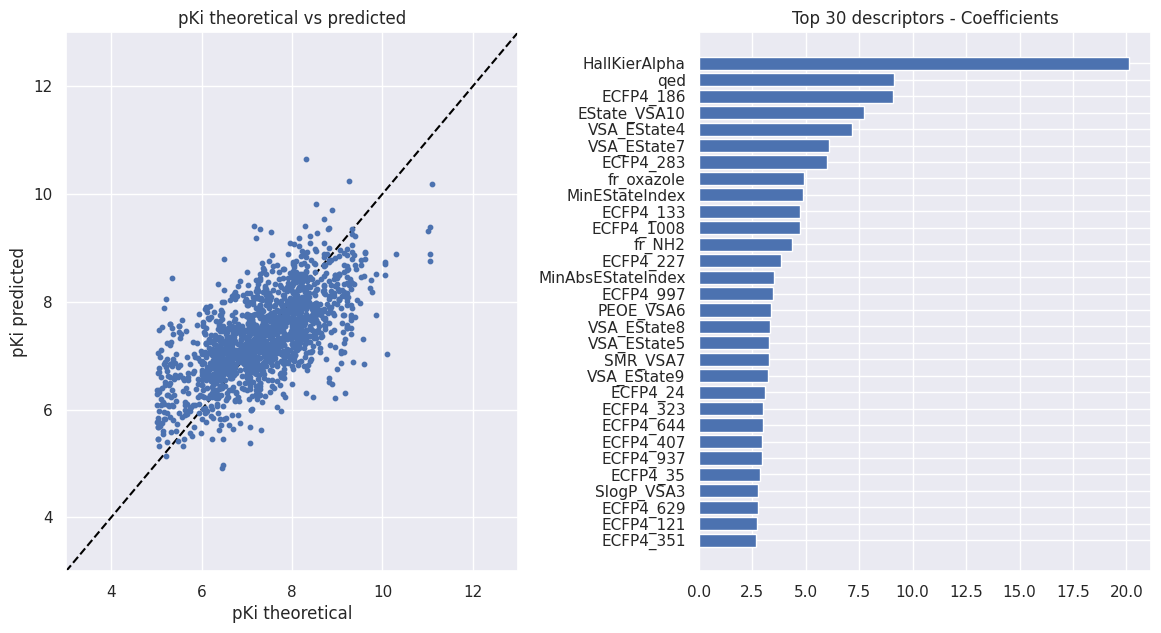

In [25]:
# @title <b>Quantitative - Multiple Linear Regression</b>

# @markdown Activate the option below to select the top X descriptors based on their coefficient. By default, run the linear regression using all available descriptors.
topX_descriptors = False # @param {type:"boolean"}
topX = 30 # @param {type:"integer"}

reglin_model = LinearRegression(positive=True).fit(X_train, y_train)
coefs = pd.DataFrame(reglin_model.coef_, columns=["Coefficients"], index=X_train.columns)

if topX_descriptors:
  X_train_subset = X_train[coefs.sort_values("Coefficients", ascending=False).head(topX).index]
  reglin_model = LinearRegression(positive=True).fit(X_train_subset, y_train)
  coefs = pd.DataFrame(reglin_model.coef_, columns=["Coefficients"], index=X_train_subset.columns)

reglin_y_pred = reglin_model.predict(X_test[reglin_model.feature_names_in_])

reglin_mse = mean_squared_error(y_test, reglin_y_pred)
reglin_rmse = np.sqrt(reglin_mse)
reglin_r2 = r2_score(y_test, reglin_y_pred)

print(f"Mean Squared Error (MSE) of Linear Regression: {reglin_mse:.2f}")
print(f"Root Mean Squared Error (RMSE) of Linear Regression: {reglin_rmse:.2f}")
print(f"R-squared (R2) of Linear Regression: {reglin_r2:.2f}\n")

reglin_predicted = pd.DataFrame({"Name":desc_CAH2_topredict_nocorr["Name"], "Predicted pKi":reglin_model.predict(desc_CAH2_topredict_nocorr[reglin_model.feature_names_in_])})
display(reglin_predicted)

plt.figure(figsize=(14,7))
plt.subplots_adjust(wspace=0.4)

plt.subplot(121)
plt.scatter(y_test, reglin_y_pred, s=10, zorder=22)
plt.axline((0, 0), slope=1, linestyle="dashed", c="black")
plt.xlim([3,13])
plt.ylim([3,13])
plt.xlabel("pKi theoretical")
plt.ylabel("pKi predicted")
plt.title("pKi theoretical vs predicted")

if topX_descriptors:
  coefs = coefs.sort_values("Coefficients", ascending=True)
  plt.subplot(122)
  plt.barh(coefs.index, coefs["Coefficients"])
  plt.title("Top {} descriptors - Coefficients".format(topX))
else:
  coefs = coefs.sort_values("Coefficients", ascending=True)
  coefs_top30 = coefs.iloc[len(coefs)-30:,:]
  plt.subplot(122)
  plt.barh(coefs_top30.index, coefs_top30["Coefficients"])
  plt.title("Top 30 descriptors - Coefficients")

plt.show()



building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:  1.2min


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


,Name,Predicted pKi
0,ToPredict_24,7.611398
1,ToPredict_21,7.377174
2,ToPredict_15,7.233413
3,ToPredict_39,7.348814


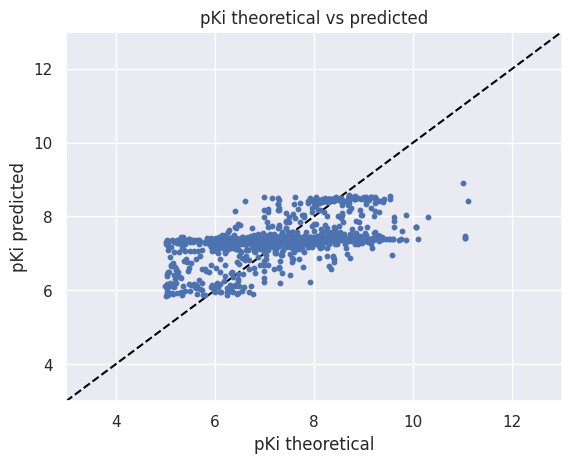

In [27]:
# @title <b>Quantitative - Random Forest</b>

# @markdown Choose the number of decision trees you will generate:
number_of_trees_qt = 100 # @param {type:"integer"}

# @markdown Choose you early termination of the trees after X subdivisions
maximum_depth_qt = 4 # @param ["None", 1, 2, 3, 4, 5] {type:"raw"}

if maximum_depth_qt == "None" or maximum_depth_qt == None:
  maximum_depth_qt = None
else:
  maximum_depth_qt = int(maximum_depth_qt)

# @markdown /!\ With too many descriptors and too many trees, this can take a while to run /!\

regRF_model = RandomForestRegressor(int(number_of_trees_qt), max_depth=maximum_depth_qt, verbose=3).fit(X_train, y_train)
regRF_y_pred = regRF_model.predict(X_test[regRF_model.feature_names_in_])

regRF_mse = mean_squared_error(y_test, regRF_y_pred)
regRF_rmse = np.sqrt(regRF_mse)
regRF_r2 = r2_score(y_test, regRF_y_pred)

print(f"\nMean Squared Error (MSE) of Quantitative Random Forest: {regRF_mse:.2f}")
print(f"Root Mean Squared Error (RMSE) of Quantitative Random Forest: {regRF_rmse:.2f}")
print(f"R-squared (R2) of Quantitative Random Forest: {regRF_r2:.2f}\n")

regRF_predicted = pd.DataFrame({"Name":desc_CAH2_topredict_nocorr["Name"], "Predicted pKi":regRF_model.predict(desc_CAH2_topredict_nocorr[regRF_model.feature_names_in_])})
display(regRF_predicted)

plt.scatter(y_test, regRF_y_pred, s=10, zorder=22)
plt.axline((0, 0), slope=1, linestyle="dashed", c="black")
plt.xlim([3,13])
plt.ylim([3,13])
plt.xlabel("pKi theoretical")
plt.ylabel("pKi predicted")
plt.title("pKi theoretical vs predicted")

plt.show()


# <b><font color="#FF7777">Qualitative models - Predict a group</b></font>

In [44]:
# @title <b>Group definition</b>
# @markdown What is your pKi limit for separating the ligands you consider "active" or "inactive"?

pKi_limit = 7.5 # @param {type:"raw"}

y_train_activity_label = ["Active" if i > pKi_limit else "Inactive" for i in y_train]
y_train_activity = [1 if i > pKi_limit else 0 for i in y_train]

y_test_activity_label = ["Active" if i > pKi_limit else "Inactive" for i in y_test]
y_test_activity = [1 if i > pKi_limit else 0 for i in y_test]

print("With a pKi limit fixed at {}:".format(pKi_limit))
print(" - {} actives (Above pKi {})".format(pd.value_counts(y_train_activity_label)["Active"], pKi_limit))
print(" - {} inactives (Below pKi {})".format(pd.value_counts(y_train_activity_label)["Inactive"], pKi_limit))

With a pKi limit fixed at 7.5:
 - 2192 actives (Above pKi 7.5)
 - 2707 inactives (Below pKi 7.5)


Linear Discriminant Analysis metrics:
 - Accuracy train = 0.871
 - Accuracy test = 0.754
 - Precision = 0.77
 - Recall = 0.716



,Name,Predicted group
0,ToPredict_24,Active
1,ToPredict_21,Active
2,ToPredict_15,Inactive
3,ToPredict_39,Inactive


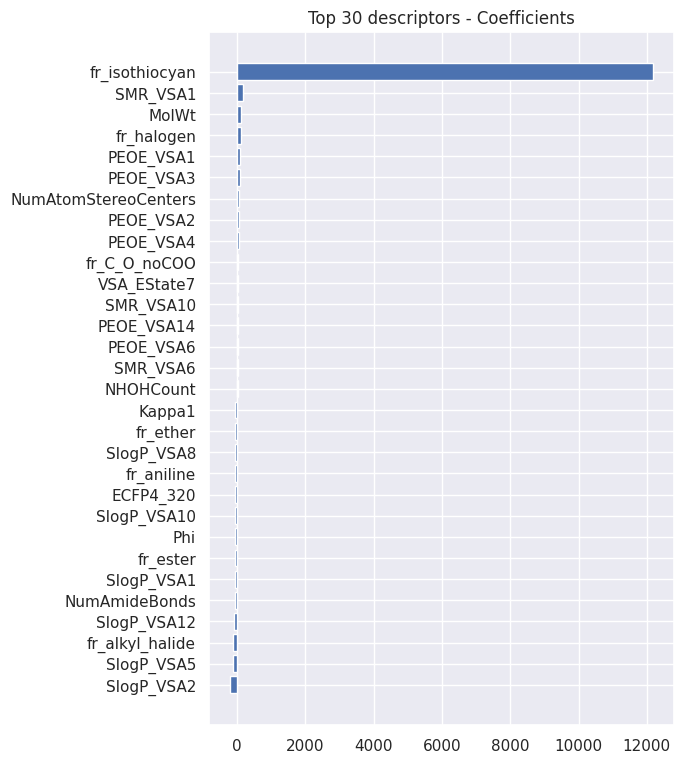

In [45]:
# @title <b>Qualitative - Linear Discriminant Analysis</b>
# @markdown Activate the option below to select the top X descriptors based on their coefficient. By default, run the LDA using all available descriptors.
lda_topX_descriptors = False # @param {type:"boolean"}
lda_topX = 100 # @param {type:"integer"}

lda_model = LinearDiscriminantAnalysis(store_covariance=True).fit(X_train, y_train_activity)

lda_coefs = pd.DataFrame(lda_model.coef_[0], columns=["Coefficients"], index=X_train.columns)

if lda_topX_descriptors:
  X_train_subset = X_train[lda_coefs["Coefficients"].abs().sort_values(ascending=False).head(lda_topX).index]
  lda_model = LinearDiscriminantAnalysis(store_covariance=True).fit(X_train_subset, y_train_activity)
  lda_coefs = pd.DataFrame(lda_model.coef_[0], columns=["Coefficients"], index=X_train_subset.columns)

lda_model_prep = lda_model.predict(X_test[lda_model.feature_names_in_])

lda_model_confusion = confusion_matrix(y_test_activity, lda_model_prep, normalize="true")

names_metrics = ["Accuracy train", "Accuracy test", "Precision", "Recall"]

lda_model_metrics = [round(lda_model.score(X_train[lda_model.feature_names_in_], y_train_activity),3),
                     round(lda_model.score(X_test[lda_model.feature_names_in_], y_test_activity),3),
                     round(lda_model_confusion[1,1] / (lda_model_confusion[1,1] + lda_model_confusion[0,1]), 3),
                     round(lda_model_confusion[1,1] / (lda_model_confusion[1,1] + lda_model_confusion[1,0]), 3)]

print("Linear Discriminant Analysis metrics:")
for i in range(4):
  print(" - {} = {}".format(names_metrics[i], lda_model_metrics[i]))

print("")
lda_predicted = lda_model.predict(desc_CAH2_topredict_nocorr[lda_model.feature_names_in_])
lda_predicted_label = ["Active" if i == 1 else "Inactive" for i in lda_predicted]
lda_predicted_df = pd.DataFrame({"Name":desc_CAH2_topredict_nocorr["Name"], "Predicted group":lda_predicted_label})
display(lda_predicted_df)


plt.figure(figsize=(6,9))
if lda_topX_descriptors:
  coefs = lda_coefs.loc[lda_coefs["Coefficients"].abs().sort_values(ascending=False).head(lda_topX).index].sort_values("Coefficients", ascending=True)
  plt.barh(coefs.index, coefs["Coefficients"])
  plt.title("Top {} descriptors - Coefficients".format(lda_topX))
else:
  coefs = lda_coefs.loc[lda_coefs["Coefficients"].abs().sort_values(ascending=False).head(30).index].sort_values("Coefficients", ascending=True)
  plt.barh(coefs.index, coefs["Coefficients"])
  plt.title("Top 30 descriptors - Coefficients")
plt.show()

In [48]:
# @title <b>Qualitative - Random Forest</b>

# @markdown Choose the number of decision trees you will generate:
number_of_trees_ql = 100 # @param {type:"integer"}

# @markdown Choose if you set an early termination of the trees after X splits, or just build the bigger trees you can (= None)
maximum_depth_ql = "5" # @param ["None", 1, 2, 3, 4, 5]

if maximum_depth_ql == "None":
  maximum_depth_ql = None
else:
  maximum_depth_ql = int(maximum_depth_ql)

classRF_model = RandomForestClassifier(n_estimators = number_of_trees_ql, max_depth = maximum_depth_ql, verbose=3).fit(X_train, y_train_activity)

classRF_model_prep = classRF_model.predict(X_test)
classRF_model_confusion = confusion_matrix(y_test_activity, classRF_model_prep, normalize="true")

names_metrics = ["Accuracy train", "Accuracy test", "Precision", "Recall"]

classRF_model_metrics = [round(classRF_model.score(X_train, y_train_activity),3),
                     round(classRF_model.score(X_test, y_test_activity),3),
                     round(classRF_model_confusion[1,1] / (classRF_model_confusion[1,1] + classRF_model_confusion[0,1]), 3),
                     round(classRF_model_confusion[1,1] / (classRF_model_confusion[1,1] + classRF_model_confusion[1,0]), 3)]

print("Qualitative Random Forest metrics:")
for i in range(4):
  print(" - {} = {}".format(names_metrics[i], classRF_model_metrics[i]))

print("")
classRF_predicted = classRF_model.predict(desc_CAH2_topredict_nocorr[classRF_model.feature_names_in_])
classRF_predicted_label = ["Active" if i == 1 else "Inactive" for i in classRF_predicted]
classRF_predicted_df = pd.DataFrame({"Name":desc_CAH2_topredict_nocorr["Name"], "Predicted group":classRF_predicted_label})
display(classRF_predicted_df)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    4.5s


building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.1s finished
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


,Name,Predicted group
0,ToPredict_24,Active
1,ToPredict_21,Inactive
2,ToPredict_15,Inactive
3,ToPredict_39,Inactive


In [52]:
# @title <b>Qualitative - Articial Neural Networks</b>

# @markdown Number of hidden layers:
nb_layers = 1 # @param [1,2,3,4,5] {type:"raw"}

# @markdown Number of nodes per hidden layers:
layer1 = 100 # @param {type:"integer"}
layer2 = 100 # @param {type:"integer"}
layer3 = 100 # @param {type:"integer"}
layer4 = 100 # @param {type:"integer"}
layer5 = 100 # @param {type:"integer"}

# @markdown Activation function:
activation_function = "relu" # @param ["identity", "logistic", "tanh", "relu"] {type:"string"}

# @markdown Solver for weight optimization:
solver_opt = "adam" # @param ["adam", "lbfgs"] {type:"string"}

# @markdown Maximum iterations:
max_iter = 500 # @param {type:"integer"}

################################################################################

if nb_layers == 1:
  if layer1 <= 0:
    raise ValueError('Wrong setup - You have a wrong number nodes for some of hidden layers')
  custom_layer_sizes=(layer1)
elif nb_layers == 2:
  if layer1 <= 0 or layer2 <= 0:
    raise ValueError('Wrong setup - You have a wrong number nodes for some of hidden layers')
  custom_layer_sizes=(layer1, layer2)
elif nb_layers == 3:
  if layer1 <= 0 or layer2 <= 0 or layer3 <= 0:
    raise ValueError('Wrong setup - You have a wrong number nodes for some of hidden layers')
  custom_layer_sizes=(layer1, layer2, layer3)
elif nb_layers == 4:
  if layer1 <= 0 or layer2 <= 0 or layer3 <= 0 or layer4 <= 0:
    raise ValueError('Wrong setup - You have a wrong number nodes for some of hidden layers')
  custom_layer_sizes=(layer1, layer2, layer3, layer4)
else :
  if layer1 <= 0 or layer2 <= 0 or layer3 <= 0 or layer4 <= 0 or layer5 <= 0:
    raise ValueError('Wrong setup - You have a wrong number nodes for some of hidden layers')
  custom_layer_sizes=(layer1, layer2, layer3, layer4, layer5)

ann_model = MLPClassifier(hidden_layer_sizes=custom_layer_sizes, activation = activation_function, verbose = True, solver = solver_opt, alpha=1e-4, max_iter= max_iter).fit(X_train, y_train_activity)

ann_model_prep = ann_model.predict(X_test)
ann_model_confusion = confusion_matrix(y_test_activity, ann_model_prep, normalize="true")

names_metrics = ["Accuracy train", "Accuracy test", "Precision", "Recall"]

ann_model_metrics = [round(ann_model.score(X_train, y_train_activity),3),
                     round(ann_model.score(X_test, y_test_activity),3),
                     round(ann_model_confusion[1,1] / (ann_model_confusion[1,1] + ann_model_confusion[0,1]), 3),
                     round(ann_model_confusion[1,1] / (ann_model_confusion[1,1] + ann_model_confusion[1,0]), 3)]

print("Linear Discriminant Analysis metrics:")
for i in range(4):
  print(" - {} = {}".format(names_metrics[i], ann_model_metrics[i]))

print("")
ann_predicted = ann_model.predict(desc_CAH2_topredict_nocorr[ann_model.feature_names_in_])
ann_predicted_label = ["Active" if i == 1 else "Inactive" for i in ann_predicted]
ann_predicted_df = pd.DataFrame({"Name":desc_CAH2_topredict_nocorr["Name"], "Predicted group":ann_predicted_label})
display(ann_predicted_df)

Iteration 1, loss = 0.68137666
Iteration 2, loss = 0.62393984
Iteration 3, loss = 0.56599529
Iteration 4, loss = 0.51574064
Iteration 5, loss = 0.47792835
Iteration 6, loss = 0.44891011
Iteration 7, loss = 0.42492349
Iteration 8, loss = 0.40471625
Iteration 9, loss = 0.38785224
Iteration 10, loss = 0.37184472
Iteration 11, loss = 0.35777627
Iteration 12, loss = 0.34508748
Iteration 13, loss = 0.33371837
Iteration 14, loss = 0.32270090
Iteration 15, loss = 0.31242275
Iteration 16, loss = 0.30276194
Iteration 17, loss = 0.29374680
Iteration 18, loss = 0.28515735
Iteration 19, loss = 0.27655323
Iteration 20, loss = 0.26819031
Iteration 21, loss = 0.26109054
Iteration 22, loss = 0.25374732
Iteration 23, loss = 0.24615203
Iteration 24, loss = 0.23940827
Iteration 25, loss = 0.23201515
Iteration 26, loss = 0.22599954
Iteration 27, loss = 0.21908122
Iteration 28, loss = 0.21379675
Iteration 29, loss = 0.20741384
Iteration 30, loss = 0.20157084
Iteration 31, loss = 0.19618839
Iteration 32, los

,Name,Predicted group
0,ToPredict_24,Active
1,ToPredict_21,Active
2,ToPredict_15,Inactive
3,ToPredict_39,Inactive
